# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras_hist_graph import plot_history

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features
print(keras.__version__)

Using TensorFlow backend.


2.3.1


import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [3]:
train_dir = 'dogs_224/train/'
validation_dir = 'dogs_224/validation/'
test_dir = 'dogs_224/test/'

STD_SIZE = (224, 224)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel']
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 224, 224, 3)


In [5]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  236
Number of train classes:  2
Number of train samples per class: 118 

Number of validation samples:  50
Number of validation classes:  2
Number of validation samples per class: 25 

Number of test samples:  51
Number of test classes:  2
Number of test samples per class: 26 

Files for train subset for 2 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

# Model

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=3e-5),
              metrics=['acc'])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

In [8]:
hist = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_2_breeds_history', 'wb') as f:
    pickle.dump(hist.history, f)

Epoch 1/1000
 - 3s - loss: 0.6755 - acc: 0.5972 - val_loss: 0.6743 - val_acc: 0.6000

Epoch 00001: val_loss improved from inf to 0.67427, saving model to cnn_from_scratch_2_breeds
Epoch 2/1000
 - 1s - loss: 0.6448 - acc: 0.6409 - val_loss: 0.7186 - val_acc: 0.4000

Epoch 00002: val_loss did not improve from 0.67427
Epoch 3/1000
 - 0s - loss: 0.6059 - acc: 0.6887 - val_loss: 0.7315 - val_acc: 0.3667

Epoch 00003: val_loss did not improve from 0.67427
Epoch 4/1000
 - 0s - loss: 0.6106 - acc: 0.6636 - val_loss: 0.5891 - val_acc: 0.8500

Epoch 00004: val_loss improved from 0.67427 to 0.58909, saving model to cnn_from_scratch_2_breeds
Epoch 5/1000
 - 1s - loss: 0.5406 - acc: 0.7547 - val_loss: 0.4472 - val_acc: 0.7333

Epoch 00005: val_loss improved from 0.58909 to 0.44721, saving model to cnn_from_scratch_2_breeds
Epoch 6/1000
 - 0s - loss: 0.5132 - acc: 0.7685 - val_loss: 0.5996 - val_acc: 0.6667

Epoch 00006: val_loss did not improve from 0.44721
Epoch 7/1000
 - 0s - loss: 0.4801 - acc: 

# Results

In [9]:
model.evaluate(test_features, test_labels)

51/51 [==============================] - 1s 10ms/step


[0.4419889987683764, 0.7843137383460999]

In [10]:
model.metrics_names

['loss', 'acc']

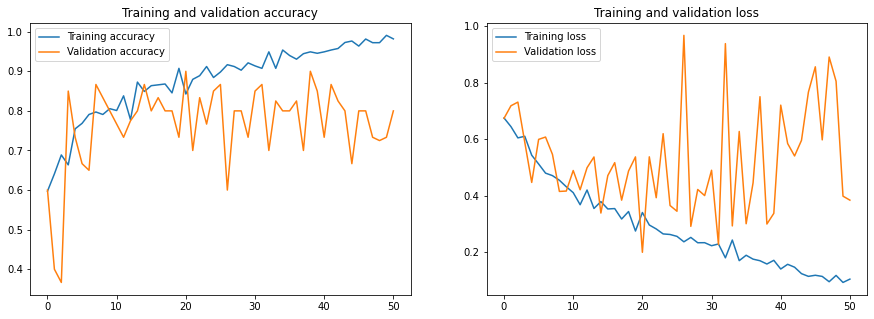

In [11]:
plot_accuracy_and_loss(hist)

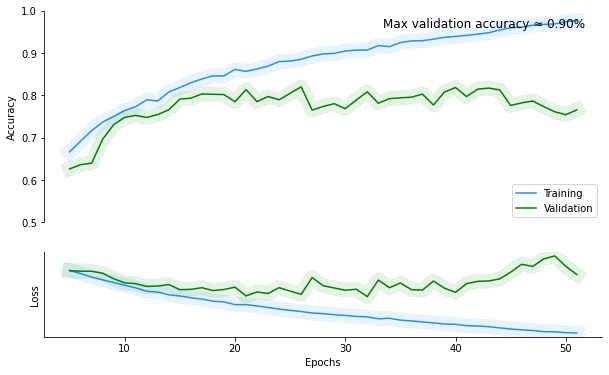

In [12]:
plot_history(hist,xkcd=False)

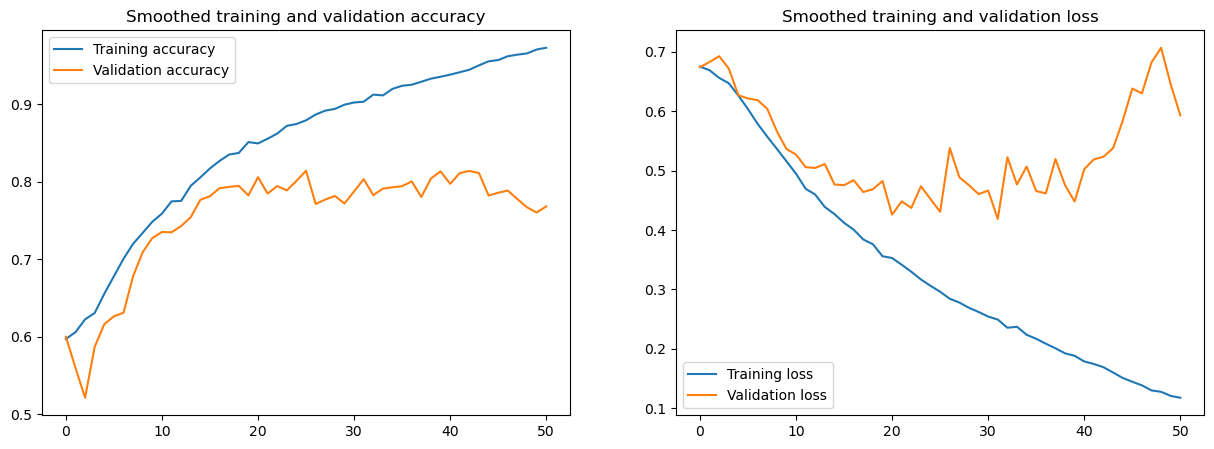

In [13]:
plot_smoothed_acc_and_loss(hist, 0.8)

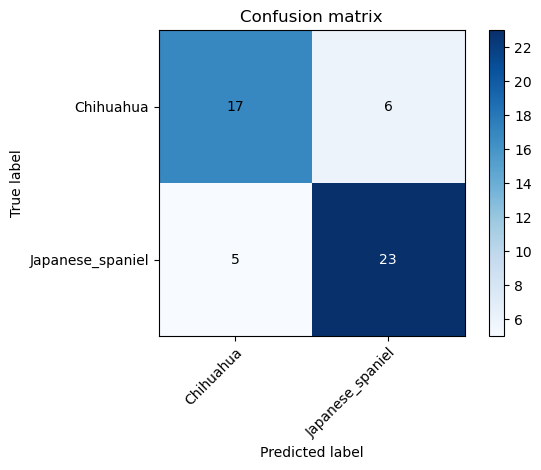

In [14]:
plot_confusion_matrix(y_true=test_labels, 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 2 breeds + data augmentation

## Data preparation

In [15]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 224, 224, 3)


In [16]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  236
Number of train classes:  2
Number of train samples per class: 118 

Number of validation samples:  50
Number of validation classes:  2
Number of validation samples per class: 25 

Number of test samples:  51
Number of test classes:  2
Number of test samples per class: 26 

Files for train subset for 2 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

# Model

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=3e-5),
              metrics=['acc'])

In [18]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_2_breeds_data_aug', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_2_breeds_data_aug_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 2s - loss: 0.6946 - acc: 0.5370 - val_loss: 0.6851 - val_acc: 0.5500

Epoch 00001: val_loss improved from inf to 0.68509, saving model to cnn_from_scratch_2_breeds_data_aug
Epoch 2/1000
 - 2s - loss: 0.6850 - acc: 0.5556 - val_loss: 0.6800 - val_acc: 0.5333

Epoch 00002: val_loss improved from 0.68509 to 0.68004, saving model to cnn_from_scratch_2_breeds_data_aug
Epoch 3/1000
 - 2s - loss: 0.6768 - acc: 0.5648 - val_loss: 0.6012 - val_acc: 0.5333

Epoch 00003: val_loss improved from 0.68004 to 0.60123, saving model to cnn_from_scratch_2_breeds_data_aug
Epoch 4/1000
 - 2s - loss: 0.6837 - acc: 0.5556 - val_loss: 0.6795 - val_acc: 0.5500

Epoch 00004: val_loss did not improve from 0.60123
Epoch 5/1000
 - 2s - loss: 0.6684 - acc: 0.5833 - val_loss: 0.6738 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.60123
Epoch 6/1000
 - 2s - loss: 0.6633 - acc: 0.6227 - val_loss: 0.7058 - val_acc: 0.5667

Epoch 00006: val_loss did not improve from 0.60123
Epoch 7/1000
 

In [19]:
model.evaluate(test_features, test_labels)

51/51 [==============================] - 0s 2ms/step


[0.37789931425861284, 0.8039215803146362]

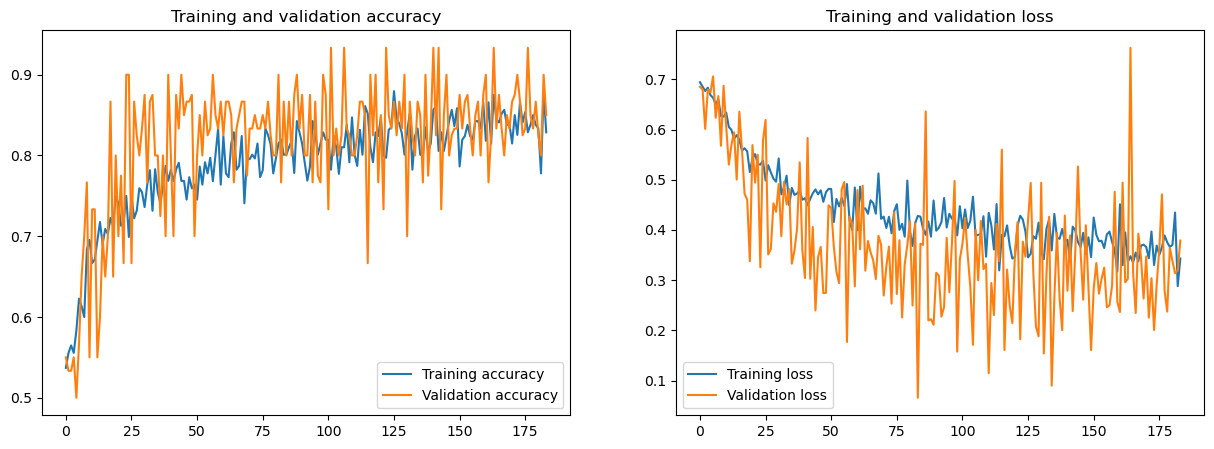

In [20]:
plot_accuracy_and_loss(history)

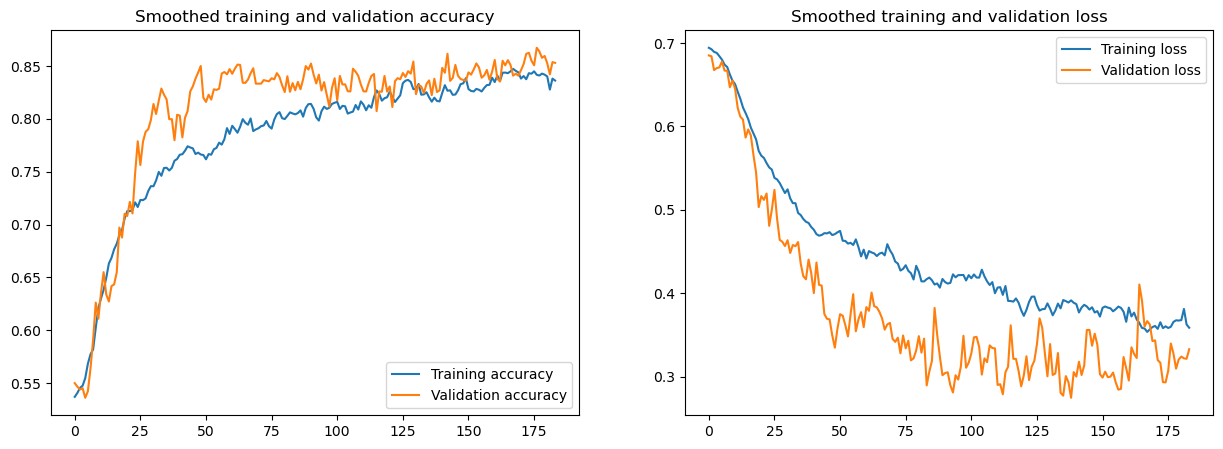

In [21]:
plot_smoothed_acc_and_loss(history, 0.8)

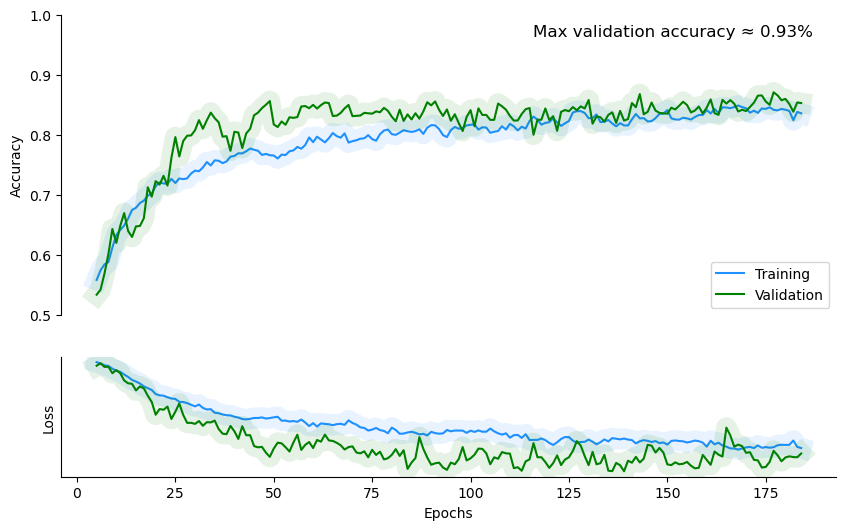

In [22]:
plot_history(history,xkcd=False)

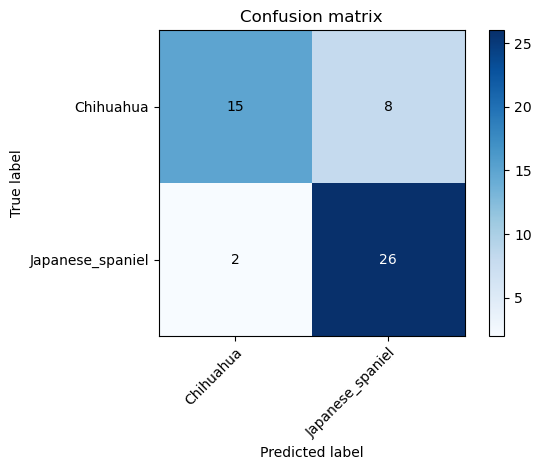

In [23]:
plot_confusion_matrix(y_true=test_labels, 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 3 breeds

## Data preparation

In [24]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 224, 224, 3)


In [25]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  412
Number of train classes:  3
Number of train samples per class: 137 

Number of validation samples:  88
Number of validation classes:  3
Number of validation samples per class: 29 

Number of test samples:  89
Number of test classes:  3
Number of test samples per class: 30 

Files for train subset for 3 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

## Model

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 1s - loss: 1.0819 - acc: 0.4337 - val_loss: 1.0975 - val_acc: 0.4125

Epoch 00001: val_loss improved from inf to 1.09751, saving model to cnn_from_scratch_3_breeds
Epoch 2/1000
 - 1s - loss: 1.0663 - acc: 0.4388 - val_loss: 1.0477 - val_acc: 0.4559

Epoch 00002: val_loss improved from 1.09751 to 1.04771, saving model to cnn_from_scratch_3_breeds
Epoch 3/1000
 - 1s - loss: 1.0676 - acc: 0.4286 - val_loss: 1.0752 - val_acc: 0.3971

Epoch 00003: val_loss did not improve from 1.04771
Epoch 4/1000
 - 1s - loss: 1.0591 - acc: 0.4150 - val_loss: 0.9935 - val_acc: 0.4412

Epoch 00004: val_loss improved from 1.04771 to 0.99352, saving model to cnn_from_scratch_3_breeds
Epoch 5/1000
 - 1s - loss: 1.0386 - acc: 0.4583 - val_loss: 1.1171 - val_acc: 0.4118

Epoch 00005: val_loss did not improve from 0.99352
Epoch 6/1000
 - 1s - loss: 1.0286 - acc: 0.4694 - val_loss: 1.0321 - val_acc: 0.4125

Epoch 00006: val_loss did not improve from 0.99352
Epoch 7/1000
 - 1s - loss: 1.0210 - acc: 

## Results

In [27]:
model.evaluate(test_features, test_labels)

89/89 [==============================] - 0s 4ms/step


[0.813308762030655, 0.6516854166984558]

In [28]:
model.metrics_names

['loss', 'acc']

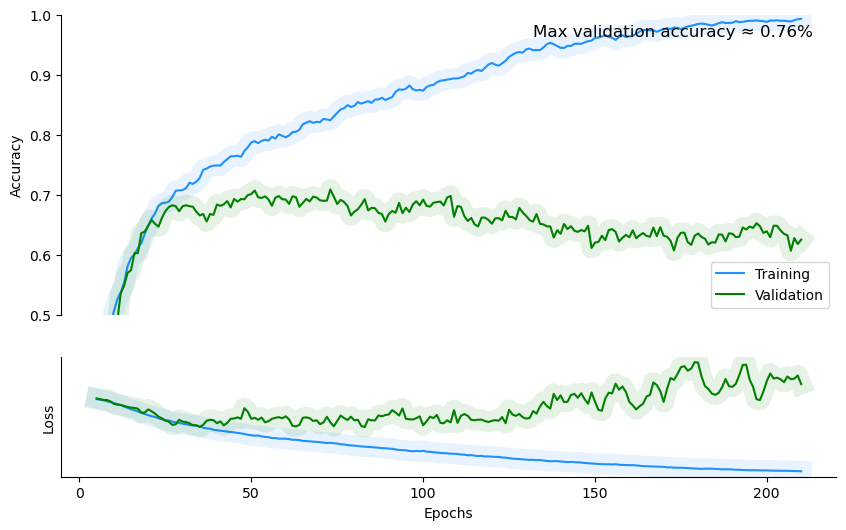

In [29]:
plot_history(history,xkcd=False)

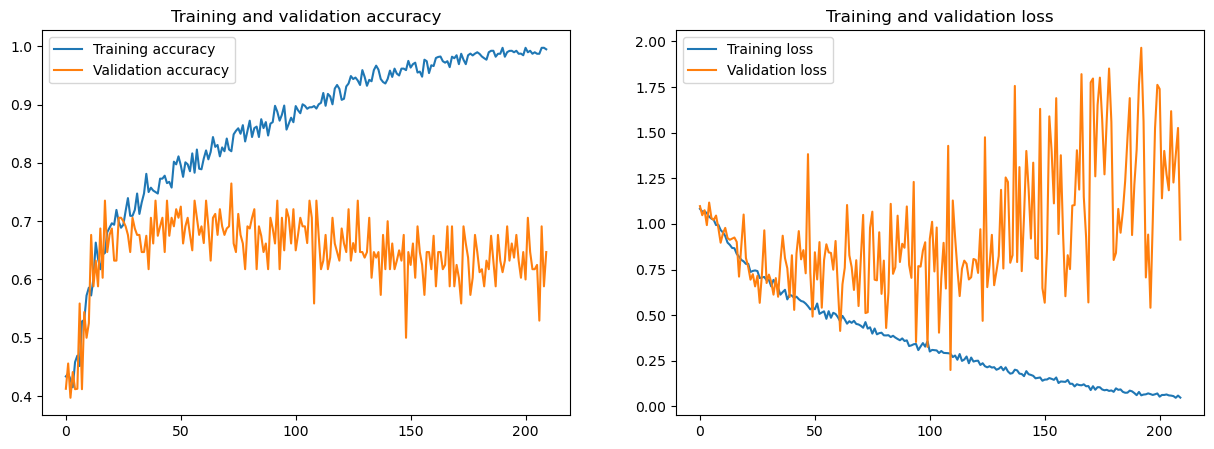

In [30]:
plot_accuracy_and_loss(history)

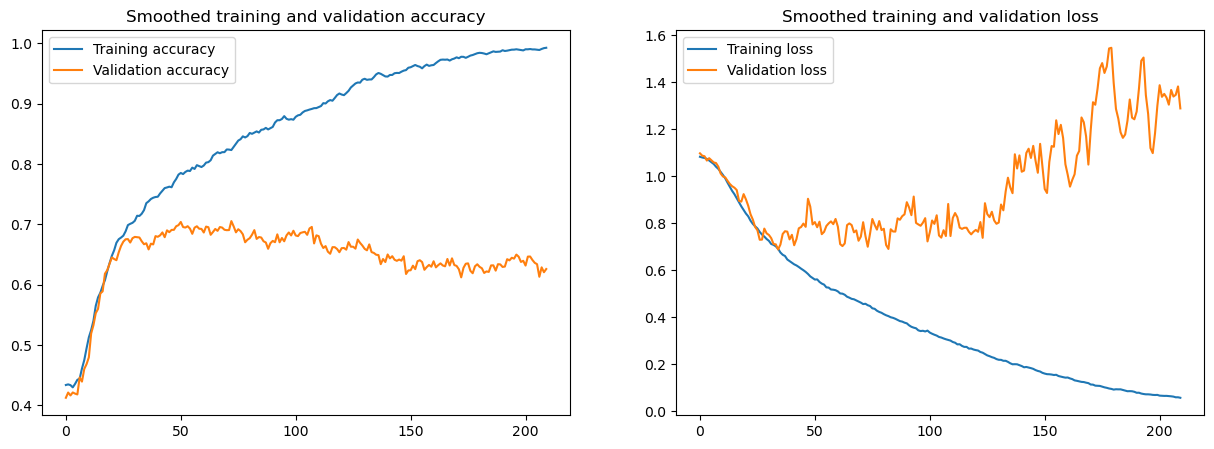

In [31]:
plot_smoothed_acc_and_loss(history, 0.8)

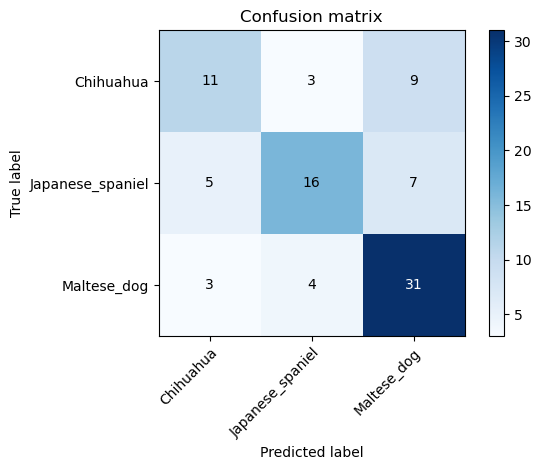

In [32]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 3 breeds + Data Augmentation

# Data preparation

In [33]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 224, 224, 3)


In [34]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', int(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', int(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', int(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  412
Number of train classes:  3
Number of train samples per class: 137 

Number of validation samples:  88
Number of validation classes:  3
Number of validation samples per class: 29 

Number of test samples:  89
Number of test classes:  3
Number of test samples per class: 29 

Files for train subset for 3 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

## Model

In [35]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_3_breeds_data_aug', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_3_breeds_data_aug_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 5s - loss: 1.0880 - acc: 0.4025 - val_loss: 1.0250 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 1.02496, saving model to cnn_from_scratch_3_breeds_data_aug
Epoch 2/1000
 - 4s - loss: 1.0751 - acc: 0.4401 - val_loss: 1.1443 - val_acc: 0.3676

Epoch 00002: val_loss did not improve from 1.02496
Epoch 3/1000
 - 4s - loss: 1.0813 - acc: 0.4235 - val_loss: 1.0270 - val_acc: 0.5441

Epoch 00003: val_loss did not improve from 1.02496
Epoch 4/1000
 - 5s - loss: 1.0743 - acc: 0.4337 - val_loss: 1.0826 - val_acc: 0.3676

Epoch 00004: val_loss did not improve from 1.02496
Epoch 5/1000
 - 4s - loss: 1.0653 - acc: 0.4362 - val_loss: 1.2137 - val_acc: 0.4412

Epoch 00005: val_loss did not improve from 1.02496
Epoch 6/1000
 - 4s - loss: 1.0783 - acc: 0.4362 - val_loss: 1.0731 - val_acc: 0.4000

Epoch 00006: val_loss did not improve from 1.02496
Epoch 7/1000
 - 4s - loss: 1.0613 - acc: 0.4260 - val_loss: 1.0579 - val_acc: 0.5147

Epoch 00007: val_loss did not improve fr

## Results

In [36]:
model.evaluate(test_features, test_labels)

89/89 [==============================] - 0s 2ms/step


[0.6608572059802795, 0.7415730357170105]

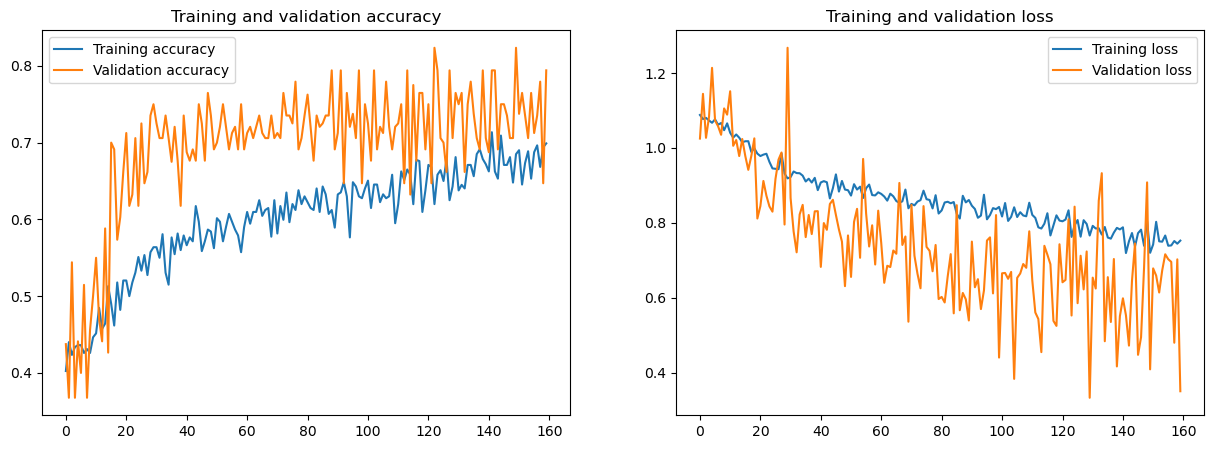

In [37]:
plot_accuracy_and_loss(history)

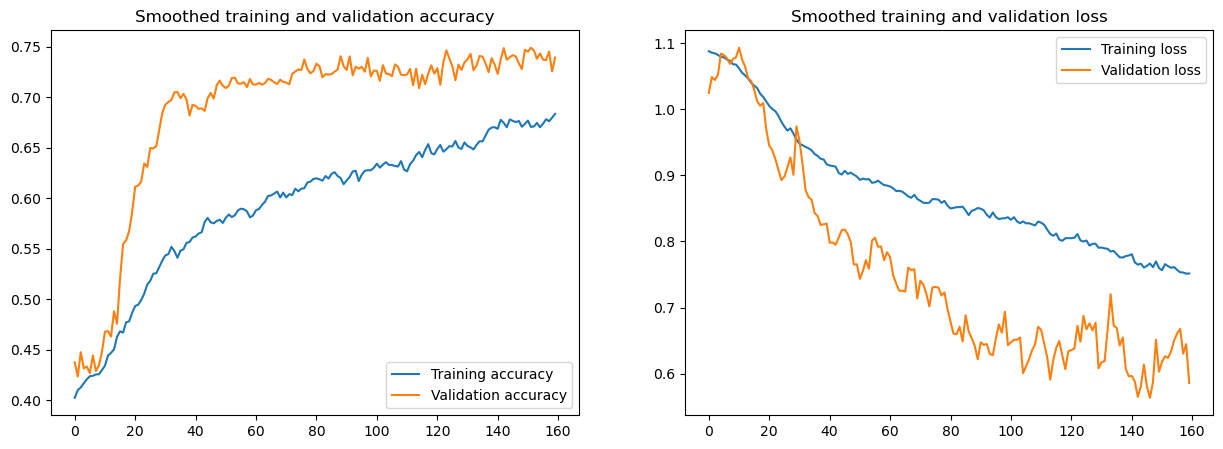

In [38]:
plot_smoothed_acc_and_loss(history, 0.8)

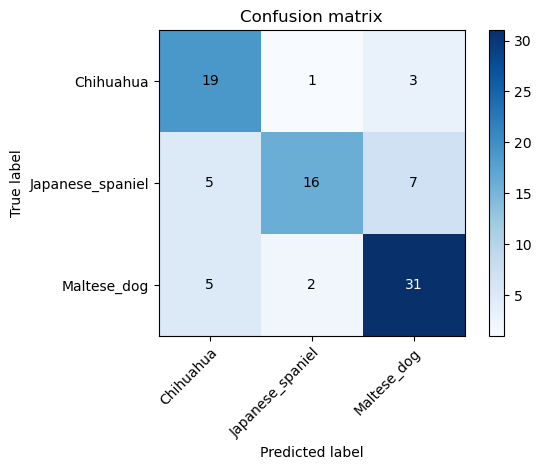

In [39]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [40]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 224, 224, 3)


In [41]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', int(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', int(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', int(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  666
Number of train classes:  5
Number of train samples per class: 133 

Number of validation samples:  143
Number of validation classes:  5
Number of validation samples per class: 28 

Number of test samples:  143
Number of test classes:  5
Number of test samples per class: 28 

Files for train subset for 5 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\

## Model

In [42]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 2s - loss: 1.6042 - acc: 0.2307 - val_loss: 1.6054 - val_acc: 0.2714

Epoch 00001: val_loss improved from inf to 1.60538, saving model to cnn_from_scratch_5_breeds
Epoch 2/1000
 - 1s - loss: 1.5841 - acc: 0.2601 - val_loss: 1.6148 - val_acc: 0.2602

Epoch 00002: val_loss did not improve from 1.60538
Epoch 3/1000
 - 1s - loss: 1.5805 - acc: 0.2786 - val_loss: 1.6222 - val_acc: 0.2683

Epoch 00003: val_loss did not improve from 1.60538
Epoch 4/1000
 - 2s - loss: 1.5763 - acc: 0.2879 - val_loss: 1.5097 - val_acc: 0.2927

Epoch 00004: val_loss improved from 1.60538 to 1.50973, saving model to cnn_from_scratch_5_breeds
Epoch 5/1000
 - 1s - loss: 1.5657 - acc: 0.2848 - val_loss: 1.5764 - val_acc: 0.2846

Epoch 00005: val_loss did not improve from 1.50973
Epoch 6/1000
 - 1s - loss: 1.5646 - acc: 0.2941 - val_loss: 1.5486 - val_acc: 0.3415

Epoch 00006: val_loss did not improve from 1.50973
Epoch 7/1000
 - 1s - loss: 1.5441 - acc: 0.3235 - val_loss: 1.5406 - val_acc: 0.3252

Ep

## Results

In [43]:
model.evaluate(test_features, test_labels)

143/143 [==============================] - 0s 3ms/step


[1.3909421475617203, 0.42657342553138733]

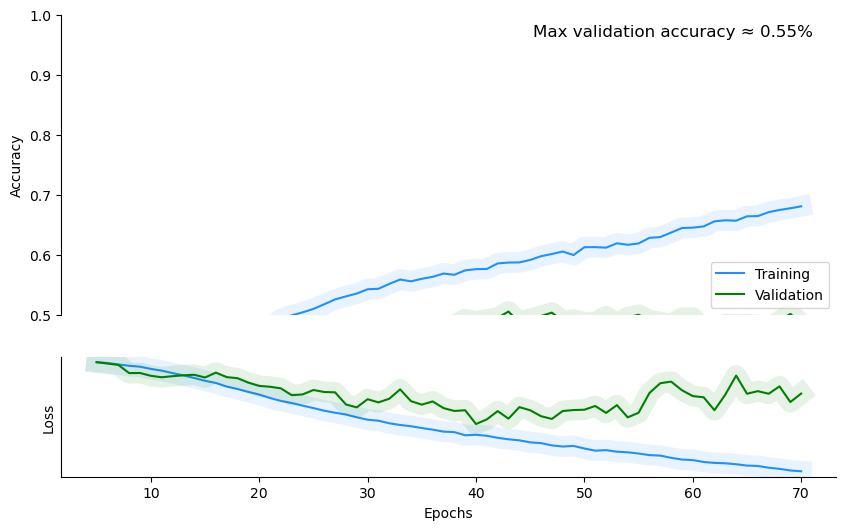

In [44]:
plot_history(history,xkcd=False)

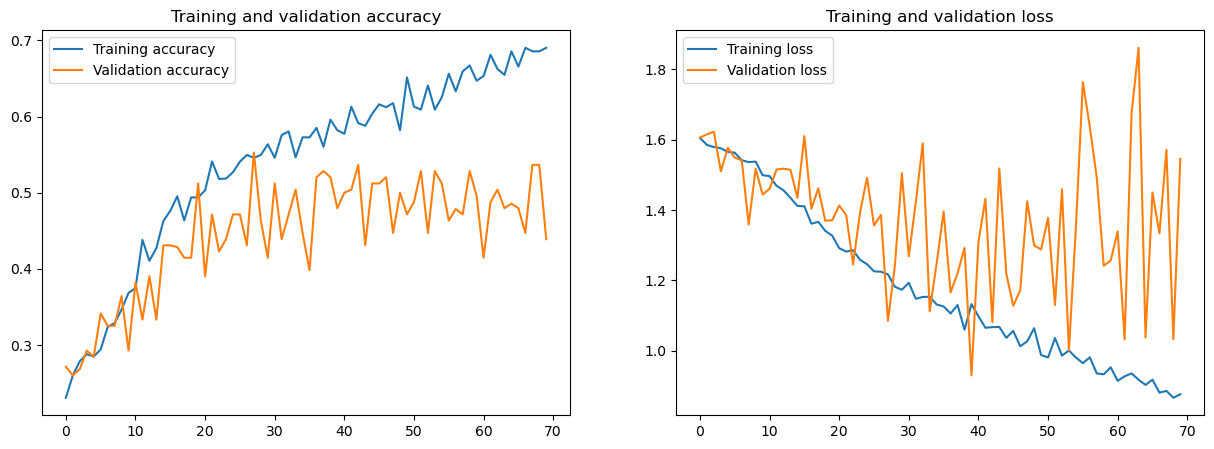

In [45]:
plot_accuracy_and_loss(history)

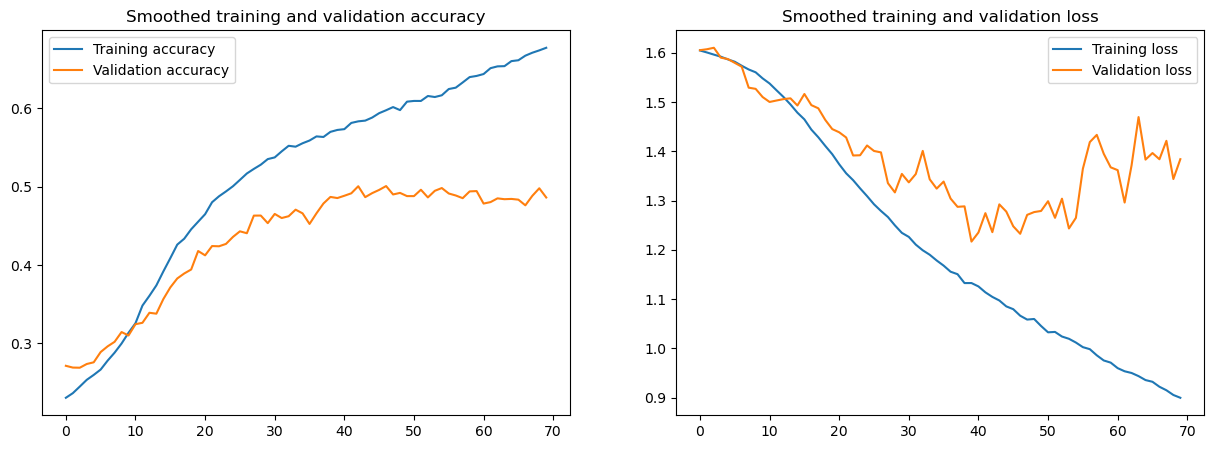

In [46]:
plot_smoothed_acc_and_loss(history, 0.8)

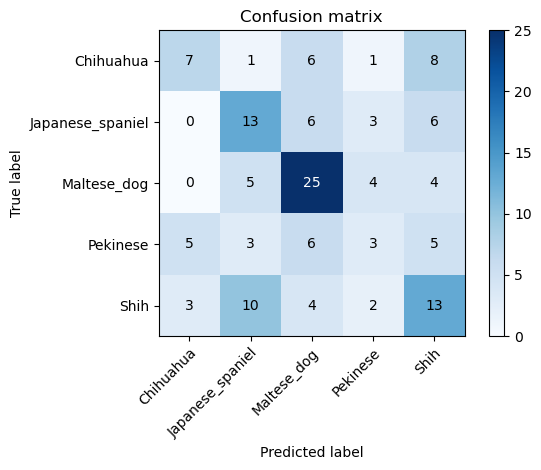

In [47]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds + Data Augmentation

## Data Preparation

In [48]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 224, 224, 3)


In [49]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', int(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', int(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', int(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  666
Number of train classes:  5
Number of train samples per class: 133 

Number of validation samples:  143
Number of validation classes:  5
Number of validation samples per class: 28 

Number of test samples:  143
Number of test classes:  5
Number of test samples per class: 28 

Files for train subset for 5 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\

## Model

In [50]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_5_breeds_data_aug', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_5_breeds_data_aug_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 7s - loss: 1.6065 - acc: 0.2198 - val_loss: 1.5959 - val_acc: 0.2571

Epoch 00001: val_loss improved from inf to 1.59594, saving model to cnn_from_scratch_5_breeds_data_aug
Epoch 2/1000
 - 8s - loss: 1.5935 - acc: 0.2601 - val_loss: 1.5785 - val_acc: 0.2602

Epoch 00002: val_loss improved from 1.59594 to 1.57853, saving model to cnn_from_scratch_5_breeds_data_aug
Epoch 3/1000
 - 8s - loss: 1.5878 - acc: 0.2663 - val_loss: 1.6076 - val_acc: 0.2683

Epoch 00003: val_loss did not improve from 1.57853
Epoch 4/1000
 - 7s - loss: 1.5898 - acc: 0.2554 - val_loss: 1.6369 - val_acc: 0.2846

Epoch 00004: val_loss did not improve from 1.57853
Epoch 5/1000
 - 7s - loss: 1.5771 - acc: 0.2616 - val_loss: 1.5627 - val_acc: 0.2602

Epoch 00005: val_loss improved from 1.57853 to 1.56268, saving model to cnn_from_scratch_5_breeds_data_aug
Epoch 6/1000
 - 7s - loss: 1.5771 - acc: 0.2895 - val_loss: 1.6428 - val_acc: 0.2520

Epoch 00006: val_loss did not improve from 1.56268
Epoch 7/1000
 

## Results

In [51]:
model.evaluate(test_features, test_labels)

143/143 [==============================] - 0s 2ms/step


[1.3525438767213087, 0.4755244851112366]

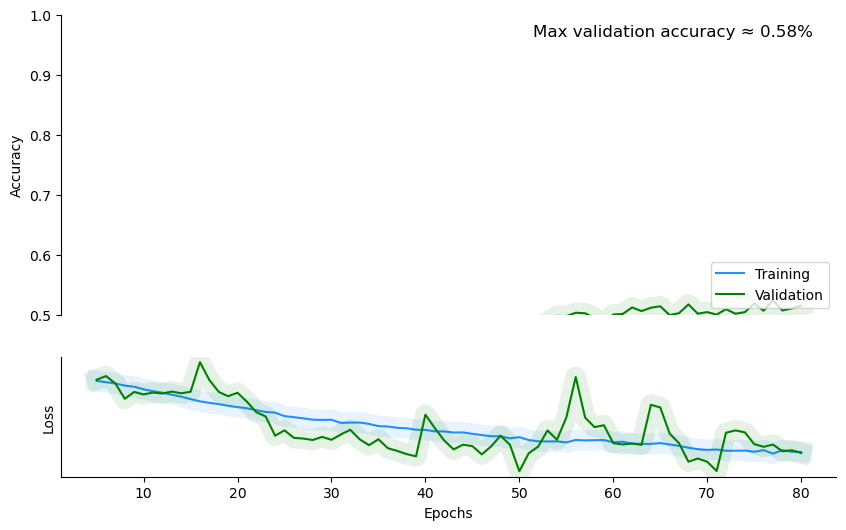

In [52]:
plot_history(history,xkcd=False)

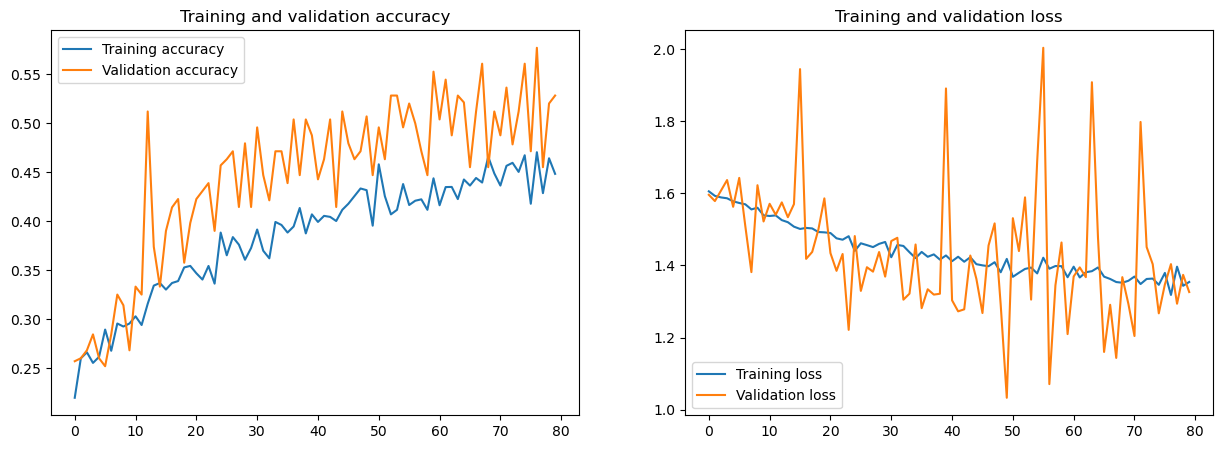

In [53]:
plot_accuracy_and_loss(history)

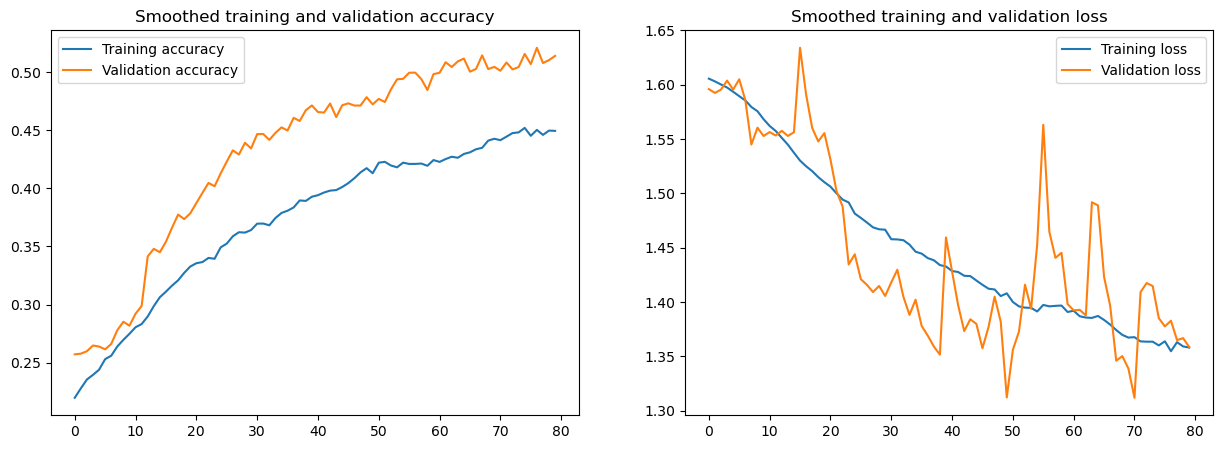

In [54]:
plot_smoothed_acc_and_loss(history, 0.8)

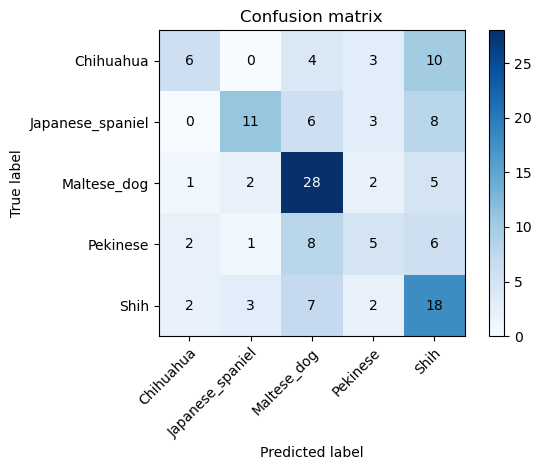

In [55]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

## 60 breeds

## Data preparation

In [56]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

In [57]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', int(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', int(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', int(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  7072
Number of train classes:  60
Number of train samples per class: 117 

Number of validation samples:  1527
Number of validation classes:  60
Number of validation samples per class: 25 

Number of test samples:  1512
Number of test classes:  60
Number of test samples per class: 25 

Files for train subset for 60 classes 
 ['affenpinscher\\n02110627_10147.jpg', 'affenpinscher\\n02110627_10185.jpg', 'affenpinscher\\n02110627_10225.jpg', 'affenpinscher\\n02110627_10437.jpg', 'affenpinscher\\n02110627_10439.jpg', 'affenpinscher\\n02110627_10447.jpg', 'affenpinscher\\n02110627_10680.jpg', 'affenpinscher\\n02110627_10787.jpg', 'affenpinscher\\n02110627_10848.jpg', 'affenpinscher\\n02110627_10859.jpg', 'affenpinscher\\n02110627_10986.jpg', 'affenpinscher\\n02110627_11211.jpg', 'affenpinscher\\n02110627_11262.jpg', 'affenpinscher\\n02110627_11263.jpg', 'affenpinscher\\n02110627_11279.jpg', 'affenpinscher\\n02110627_11283.jpg', 'affenpinscher\\n02110627_11345.jpg', 

## Model

In [58]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 38s - loss: 4.0548 - acc: 0.0313 - val_loss: 3.9350 - val_acc: 0.0434

Epoch 00001: val_loss improved from inf to 3.93495, saving model to cnn_from_scratch_60_breeds
Epoch 2/1000
 - 15s - loss: 3.7013 - acc: 0.0867 - val_loss: 3.5991 - val_acc: 0.0889

Epoch 00002: val_loss improved from 3.93495 to 3.59913, saving model to cnn_from_scratch_60_breeds
Epoch 3/1000
 - 15s - loss: 3.3941 - acc: 0.1404 - val_loss: 3.8291 - val_acc: 0.1115

Epoch 00003: val_loss did not improve from 3.59913
Epoch 4/1000
 - 15s - loss: 3.1068 - acc: 0.2039 - val_loss: 3.3489 - val_acc: 0.1161

Epoch 00004: val_loss improved from 3.59913 to 3.34891, saving model to cnn_from_scratch_60_breeds
Epoch 5/1000
 - 15s - loss: 2.7751 - acc: 0.2757 - val_loss: 3.1417 - val_acc: 0.1387

Epoch 00005: val_loss improved from 3.34891 to 3.14171, saving model to cnn_from_scratch_60_breeds
Epoch 6/1000
 - 14s - loss: 2.4226 - acc: 0.3609 - val_loss: 3.9794 - val_acc: 0.1367

Epoch 00006: val_loss did not impro

## Results

In [59]:
model.evaluate(test_features, test_labels)

1512/1512 [==============================] - 2s 2ms/step


[3.5533709425144093, 0.14153438806533813]

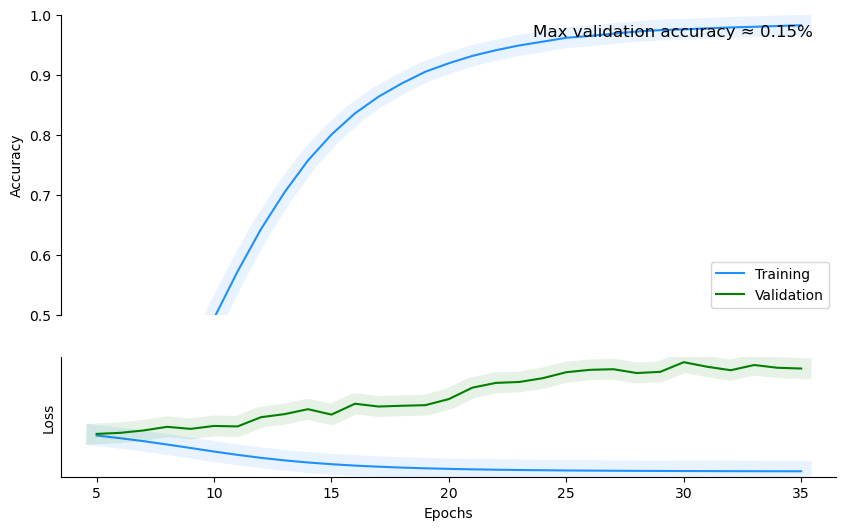

In [60]:
plot_history(history,xkcd=False)

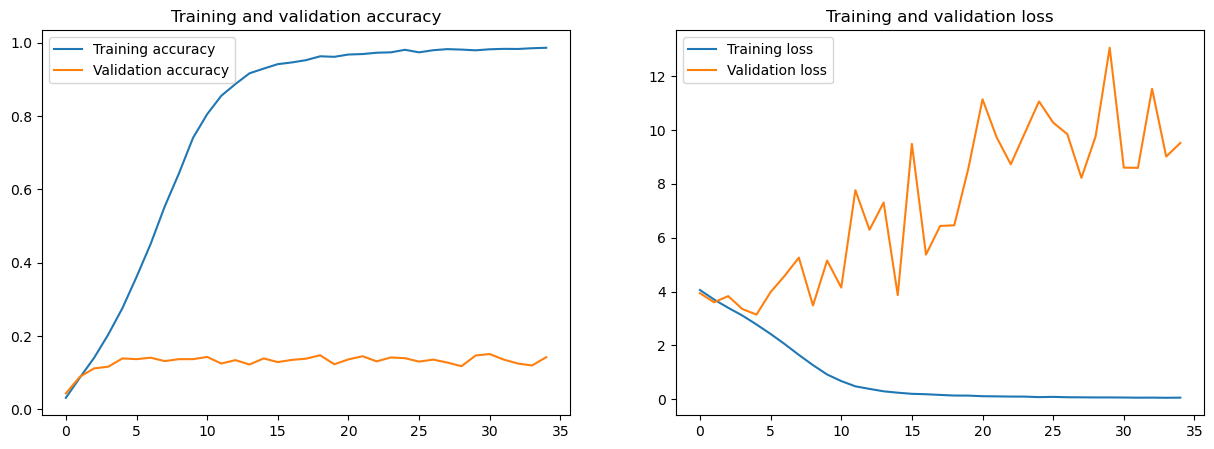

In [61]:
plot_accuracy_and_loss(history)

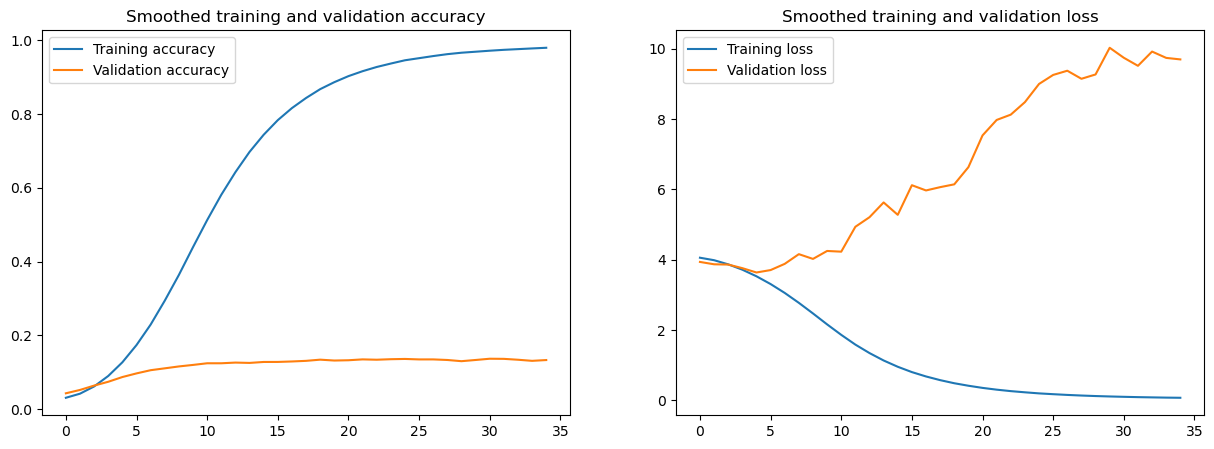

In [62]:
plot_smoothed_acc_and_loss(history, 0.8)

# 60 breeds + Data Augmentation

## Data preparation

In [4]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_60_breeds_data_aug', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_60_breeds_data_aug_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 75s - loss: 4.0663 - acc: 0.0278 - val_loss: 3.9797 - val_acc: 0.0349

Epoch 00001: val_loss improved from inf to 3.97972, saving model to cnn_from_scratch_60_breeds_data_aug
Epoch 2/1000
 - 72s - loss: 3.9199 - acc: 0.0492 - val_loss: 3.9303 - val_acc: 0.0670

Epoch 00002: val_loss improved from 3.97972 to 3.93025, saving model to cnn_from_scratch_60_breeds_data_aug
Epoch 3/1000
 - 71s - loss: 3.8084 - acc: 0.0638 - val_loss: 3.3184 - val_acc: 0.0737

Epoch 00003: val_loss improved from 3.93025 to 3.31842, saving model to cnn_from_scratch_60_breeds_data_aug
Epoch 4/1000
 - 73s - loss: 3.7426 - acc: 0.0747 - val_loss: 3.5109 - val_acc: 0.0962

Epoch 00004: val_loss did not improve from 3.31842
Epoch 5/1000
 - 73s - loss: 3.6864 - acc: 0.0849 - val_loss: 3.6493 - val_acc: 0.0849

Epoch 00005: val_loss did not improve from 3.31842
Epoch 6/1000
 - 74s - loss: 3.6309 - acc: 0.0895 - val_loss: 3.3816 - val_acc: 0.1181

Epoch 00006: val_loss did not improve from 3.31842
Epoch

## Results

In [6]:
model.evaluate(test_features, test_labels)

1512/1512 [==============================] - 6s 4ms/step


[2.9893601432679193, 0.2321428507566452]

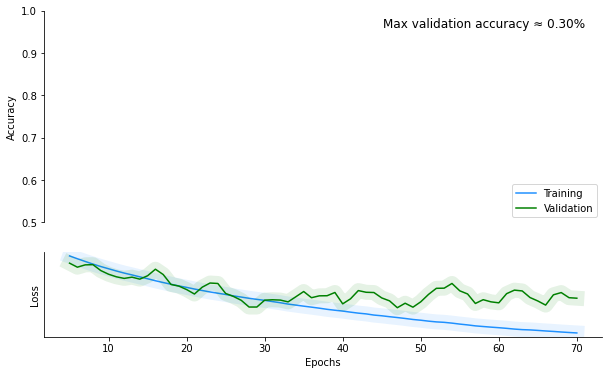

In [7]:
plot_history(history,xkcd=False)

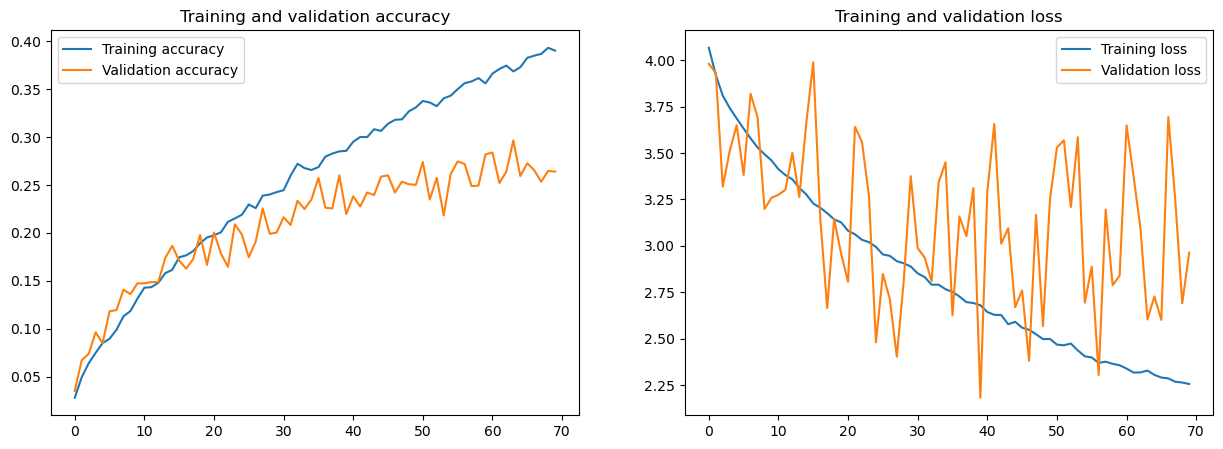

In [8]:
plot_accuracy_and_loss(history)

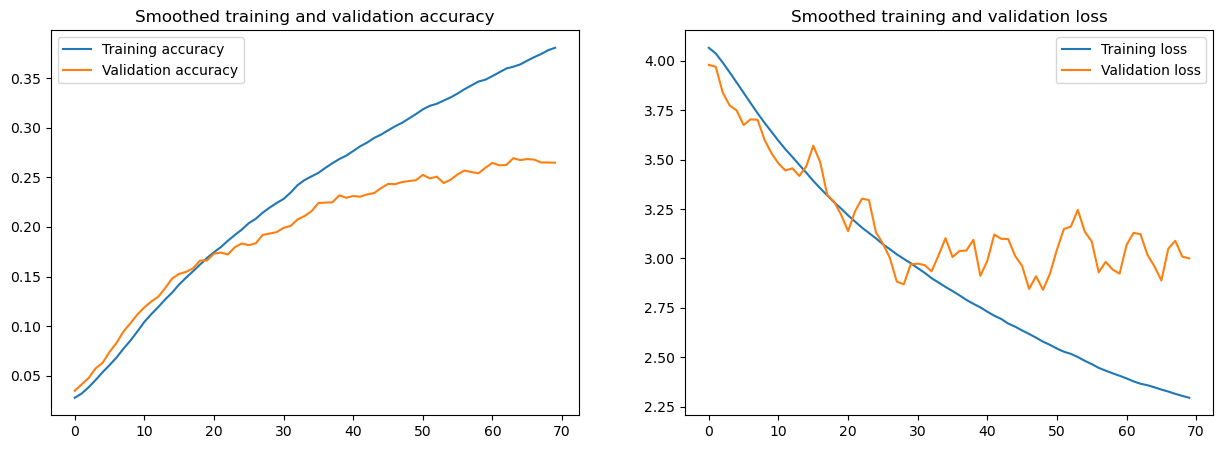

In [9]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds

## Data preparation

In [69]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

In [70]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 50s - loss: 4.7554 - acc: 0.0165 - val_loss: 4.3110 - val_acc: 0.0442

Epoch 00001: val_loss improved from inf to 4.31101, saving model to cnn_from_scratch_120_breeds
Epoch 2/1000
 - 29s - loss: 4.3485 - acc: 0.0479 - val_loss: 4.3108 - val_acc: 0.0653

Epoch 00002: val_loss improved from 4.31101 to 4.31084, saving model to cnn_from_scratch_120_breeds
Epoch 3/1000
 - 29s - loss: 4.0558 - acc: 0.0889 - val_loss: 3.9629 - val_acc: 0.0870

Epoch 00003: val_loss improved from 4.31084 to 3.96287, saving model to cnn_from_scratch_120_breeds
Epoch 4/1000
 - 29s - loss: 3.7860 - acc: 0.1356 - val_loss: 4.3754 - val_acc: 0.1020

Epoch 00004: val_loss did not improve from 3.96287
Epoch 5/1000
 - 29s - loss: 3.4876 - acc: 0.1894 - val_loss: 3.8099 - val_acc: 0.1137

Epoch 00005: val_loss improved from 3.96287 to 3.80994, saving model to cnn_from_scratch_120_breeds
Epoch 6/1000
 - 29s - loss: 3.1479 - acc: 0.2505 - val_loss: 4.5545 - val_acc: 0.1101

Epoch 00006: val_loss did not i

## Results

In [71]:
model.evaluate(test_features, test_labels)

3084/3084 [==============================] - 4s 1ms/step


[3.9555329243651314, 0.10862515866756439]

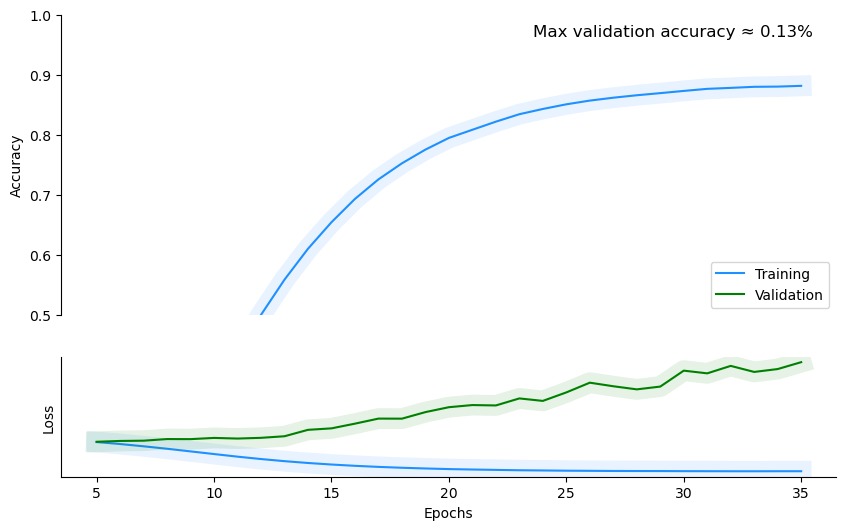

In [78]:
plot_history(history,xkcd=False)

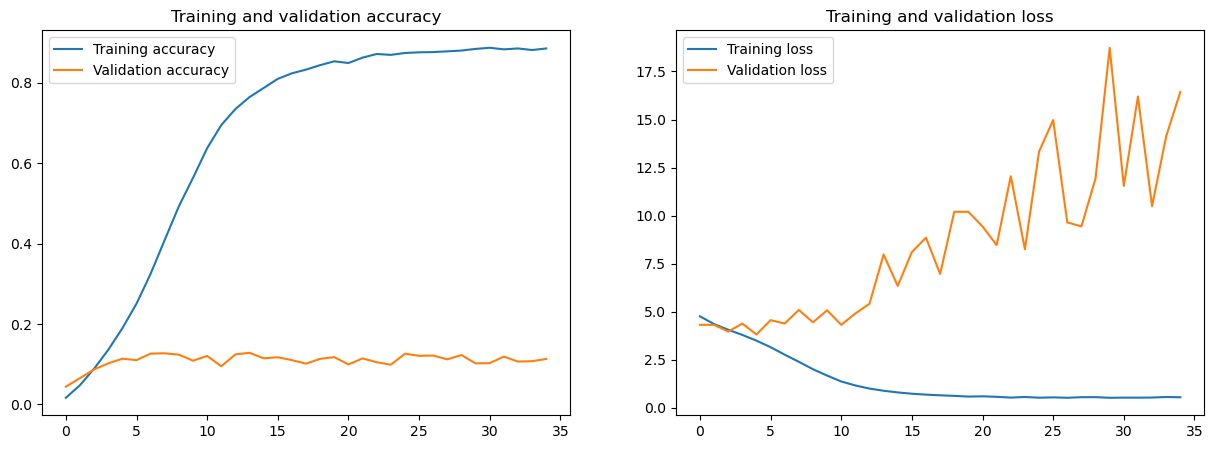

In [73]:
plot_accuracy_and_loss(history)

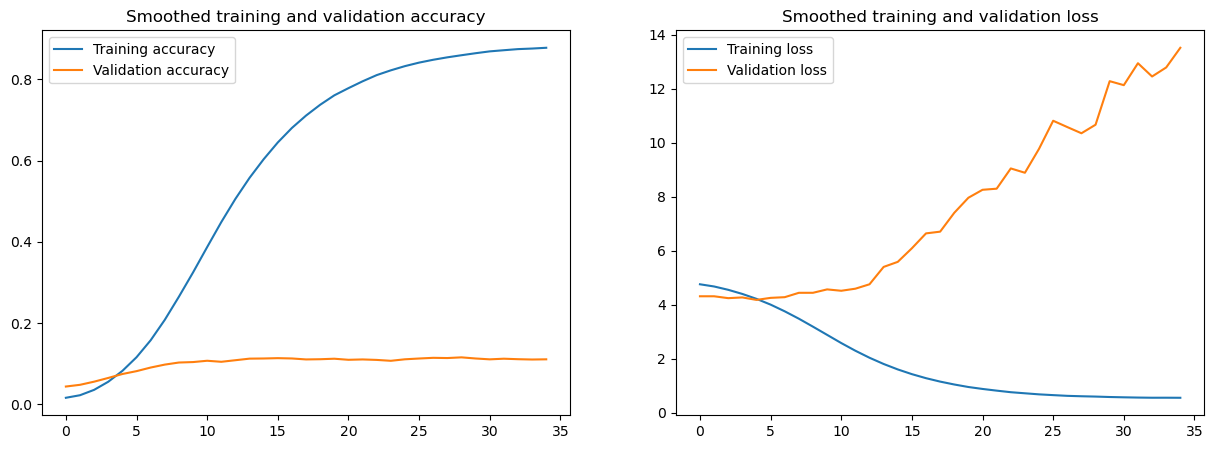

In [74]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds + data augmentation

## Data preparation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(STD_SIZE[0], STD_SIZE[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'cnn_from_scratch_120_breeds_data_aug', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'cnn_from_scratch_120_breeds_data_aug_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 162s - loss: 4.7406 - acc: 0.0134 - val_loss: 4.4513 - val_acc: 0.0292

Epoch 00001: val_loss improved from inf to 4.45129, saving model to cnn_from_scratch_120_breeds_data_aug
Epoch 2/1000
 - 145s - loss: 4.5177 - acc: 0.0280 - val_loss: 4.4987 - val_acc: 0.0510

Epoch 00002: val_loss did not improve from 4.45129
Epoch 3/1000
 - 144s - loss: 4.3913 - acc: 0.0406 - val_loss: 3.7178 - val_acc: 0.0646

Epoch 00003: val_loss improved from 4.45129 to 3.71784, saving model to cnn_from_scratch_120_breeds_data_aug
Epoch 4/1000
 - 147s - loss: 4.3028 - acc: 0.0548 - val_loss: 3.8100 - val_acc: 0.0760

Epoch 00004: val_loss did not improve from 3.71784
Epoch 5/1000
 - 142s - loss: 4.2433 - acc: 0.0616 - val_loss: 3.8946 - val_acc: 0.0802

Epoch 00005: val_loss did not improve from 3.71784
Epoch 6/1000
 - 145s - loss: 4.1878 - acc: 0.0693 - val_loss: 3.7923 - val_acc: 0.0948

Epoch 00006: val_loss did not improve from 3.71784
Epoch 7/1000
 - 144s - loss: 4.1540 - acc: 0.0777 - va

## Results

In [6]:
model.evaluate(test_features, test_labels)

3084/3084 [==============================] - 12s 4ms/step


[3.765217122710014, 0.12451361864805222]

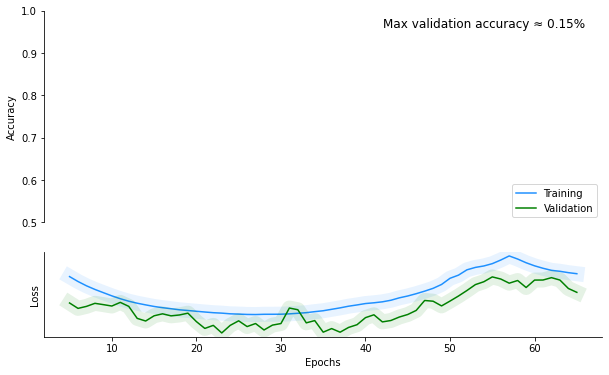

In [7]:
plot_history(history,xkcd=False)

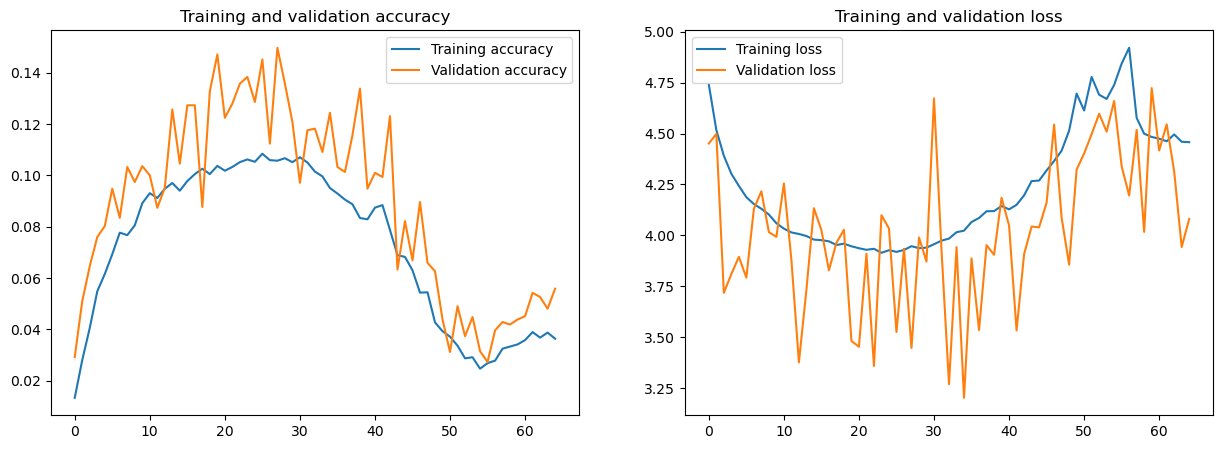

In [8]:
plot_accuracy_and_loss(history)

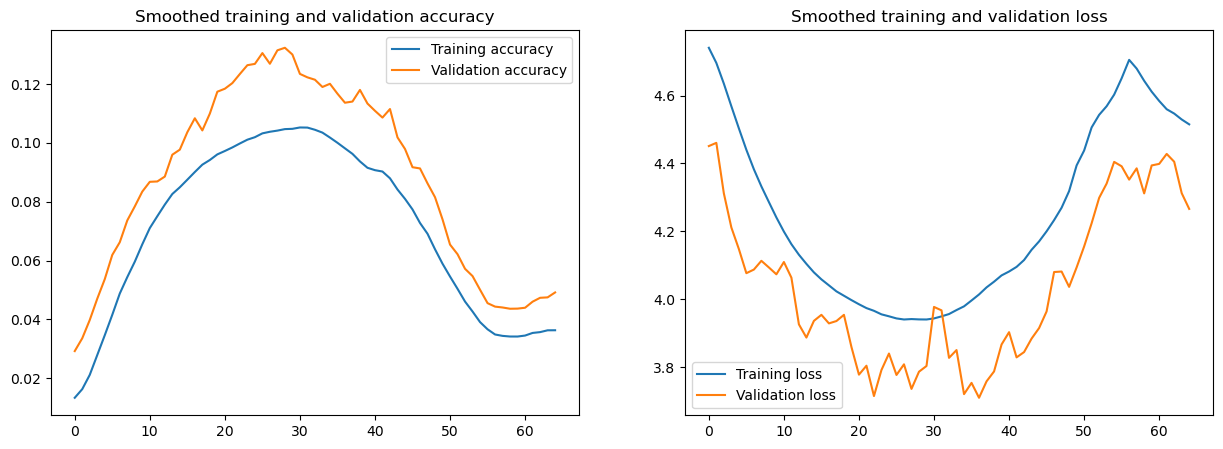

In [9]:
plot_smoothed_acc_and_loss(history, 0.8)